In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_75nm.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 0.0%

Progress: 98.53%

Calculate measures for tri type of elements
Progress: 99.83%

Calculate measures for tet type of elements
Progress: 99.97%

Calculation of measures of all elements finished in 23.61276340484619 seconds.


In [5]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T
elements = mesh.elements_coordinates

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [6]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [7]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/magnetization_75nm.txt",
    mesh=mesh,
    dim=3)

In [8]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_
del M0

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 4.558696031570435 seconds.


In [9]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 879.5247690677643 seconds.


In [11]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/H_eff_75nm.txt",
    mesh=mesh,
    dim=3)

"""_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T"""

'_H_eff = H_eff.vectorize()\nvals_H_eff = H_eff.values.T'

In [11]:
"""%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    vals_H_eff[0],
    vals_H_eff[1],
    vals_H_eff[2],
    length=0.001,
)

plt.show()"""

'%matplotlib inline\n%matplotlib widget \n\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nfig = plt.figure(figsize=(5,5), dpi=100)\nax = fig.add_subplot(projection="3d") \n\nax.quiver(\n    centers[0],\n    centers[1],\n    centers[2],\n    vals_H_eff[0],\n    vals_H_eff[1],\n    vals_H_eff[2],\n    length=0.001,\n)\n\nplt.show()'

In [12]:
H_eff_cpo = CPO(
    mesh=mesh,
    left_vector=H_eff
)
H_eff_times_ = H_eff_cpo.to_mesh_matrix()
del H_eff

Begin placement of operator on mesh elements' centers.
Progress: 0.09%

Progress: 99.97%

Mesh matric of the operator generated in 4.7606422901153564 seconds.


In [13]:
IntConvOp = matmul(M0_times_,int_G_)

In [14]:
LLG_operator = 1j * gamms * (H_eff_times_ - M_s * IntConvOp)

del IntConvOp

In [15]:
eigs = eig(LLG_operator)

In [16]:
eigenvalues = eigs.eigenvalues
eigenvectors = eigs.eigenvectors.T
#eigenvalues = (1j * np.array(eigenvalues))
eigenvalues_idx = np.where(abs(eigenvalues.imag) < 10000000)[0]
eigenvalues = eigenvalues[eigenvalues_idx].real
eigenvalues_idx = np.where(abs(eigenvalues) > 1e9)[0]
eigenvalues = eigenvalues[eigenvalues_idx]
eigenvalues, eigenvalues_idx

(tensor([-3.1203e+09,  3.1203e+09, -2.7709e+09,  2.7709e+09, -2.6470e+09,
          2.6470e+09,  2.5769e+09, -2.5769e+09, -2.5382e+09,  2.5382e+09,
         -2.4829e+09,  2.4829e+09,  2.3358e+09, -2.3358e+09, -2.3121e+09,
          2.3121e+09,  2.2706e+09,  2.2610e+09, -2.2706e+09, -2.2610e+09,
          2.2442e+09, -2.2442e+09, -2.2310e+09,  2.2310e+09, -2.2018e+09,
          2.2018e+09, -2.1343e+09,  2.1343e+09, -2.0916e+09, -2.0763e+09,
          2.0916e+09,  2.0763e+09,  2.0400e+09, -2.0400e+09,  2.0152e+09,
         -2.0152e+09, -1.9902e+09,  1.9902e+09,  1.9797e+09, -1.9797e+09,
          1.9500e+09,  1.9419e+09, -1.9500e+09, -1.9419e+09,  1.9278e+09,
         -1.9278e+09,  1.9063e+09, -1.9063e+09,  1.8866e+09, -1.8866e+09,
          1.8529e+09, -1.8529e+09,  1.8355e+09, -1.8355e+09,  1.8177e+09,
         -1.8177e+09, -1.8019e+09,  1.8019e+09,  1.7724e+09, -1.7724e+09,
         -1.7474e+09, -1.7375e+09,  1.7474e+09,  1.7375e+09, -1.7282e+09,
          1.7282e+09, -1.7145e+09,  1.

In [35]:
dm = VectorField(
    mesh=mesh,
    coordinates=mesh.elements_centers['tet'],
)
n = 1
_dm = eigenvectors[1] #+ eigenvectors[4]
dm.devectorize(np.array(_dm).real)

dm_values = dm.values.T
dm_coordinates = dm.coorrdinates.T

/tmp/ipykernel_1989/3058543976.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dm.devectorize(np.array(_dm).real)


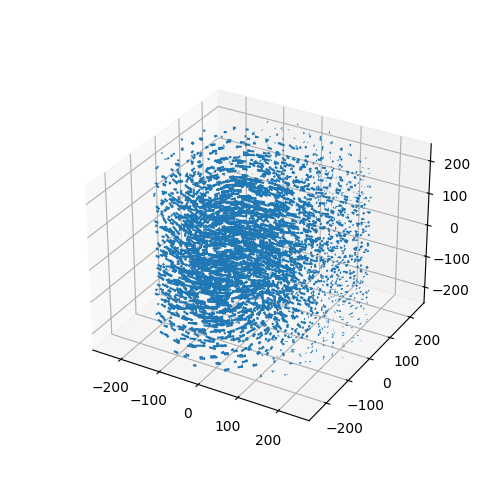

In [36]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    dm_coordinates[0],
    dm_coordinates[1],
    dm_coordinates[2],
    dm_values[0],
    dm_values[1],
    dm_values[2],
    length=900,
)

plt.show()

In [25]:
eigenvalues[0]

array([   5,    6,   13, ..., 5763, 5766, 5767])

In [130]:
5e5 * gamms

11250000000.0